In [142]:
import arcgis
import arcgiskey
from arcgis.gis import GIS
from arcgis.geometry import *
from ipywidgets import *
import geopandas as gpd
import pandas as pd
import numpy as np
import arcgis.network as network
import arcgis.geocoding as geocoding
from arcgis.features import (
    FeatureLayer,
    FeatureSet,
    FeatureCollection,
    FeatureLayerCollection,
    GeoAccessor,
    GeoSeriesAccessor,
)
import arcgis.features.use_proximity as use_proximity
from arcgis.geoenrichment import *
from arcgis.map.symbols import PictureMarkerSymbolEsriPMS
from arcgis.map.symbols import (
    SimpleFillSymbolEsriSFS,
    SimpleLineSymbolEsriSLS,
    SimpleMarkerSymbolEsriSMS,
)
from arcgis.map import renderers
from arcgis.map.renderers import SimpleRenderer
from arcgis.map.symbols import SimpleFillSymbolEsriSFS, SimpleFillSymbolStyle
from arcgis.map.symbols import SimpleLineSymbolEsriSLS, SimpleLineSymbolStyle
from shapely.geometry import (
    Point,
    MultiPoint,
    LineString,
    MultiLineString,
    Polygon,
    MultiPolygon,
)
from shapely.wkt import loads
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

gis = GIS(username = arcgiskey.USERNAME, password = arcgiskey.PASSWORD)

# 1) Project Title: Identifying points of Traffic with reasons in San Diego

Team Members: Kevin Wong (A17280855) and Lukas Fullner (A16945107) 

Class: DSC 170 Winter 2025

# 2) Questions we want to address, and their importance

Traffic Pattern Analysis
* How does traffic in urban, suburban, and rural areas differ? Specifically, what type of accidents happen most often in each respective category?
* What are the most accident-prone intersections, highways, and roads in San Diego? Identify high risk areas based on accident frequency and severity

Demographic Factors: 
* Are accidents more frequent in areas with certain demographic characteristics?
* Do different types of accidents correlate with socioeconimic factors?

When traffic accidents are portrayed on the news, they are cited as being avoidable and oftentimes the cause of reckless driving, whether that be through sleepy drivers or those under the influence. However, we propose that oftentimes, traffic is not solely caused by reckless driving and individual driver behvaior. Other factors - such as socioeconomic conditions, infrastructure design, and traffic congrestion - play a significant role and are more measurable than human error. 

By identifying areas with high traffic volume and frequent accidents (relative to their area), we aim to create an interactive map highlighting accident-prone locations and potential contributing factors. This will provide a data-driven approach to understanding traffic safety in San Diego county and offer potential areas of improve to reduce accidents.

# 3) Background and Literature

GIS in Traffic Accident Analysis

* GIS has been extensively used to study the spatial distribution of traffic accidents, identifying hotspots and danger points in road traffic. For instance, the [FeGIS](https://bmdv.bund.de/SharedDocs/DE/Artikel/DG/mfund-projekte/frueherkennung-von-gefahrenstellen-im-strassenverkehr-fegis.html) (Early Detection of Dangerous Areas in road traffic) project in Germany helped identify these "danger points", preventing accidents through timely warnings of danger zones for pedestrians and road users. It offered an outline for proactive identification of danger for EU Road Safety Policy

Statistical Methods in Traffic Safety Research 

* Statistical and econometrical methods for analyzing crash data and understanding the factors that influence accident occurrences and severities are essential to our project. Researchers like [Fred Mannering](https://en.wikipedia.org/wiki/Fred_Mannering) have contributed significantly to this field, developing models that account for accident frequency and severity based on road conditions, type, and more. 

Tools for Spaital Analysis in Traffic Studies

* Tools like [CrimeStat](https://en.wikipedia.org/wiki/CrimeStat) offer spatial statistical functionalities that can be applied to traffic accident analysis. CrimeStat's spatial analytical methods have been adapted for various applications, like finding accident hotspots and modeling travel demand related to traffic accidents.

# 4) Libaries and Modules

* Pandas - To handle dataframes and to preprocess data
* GeoPandas — Used to determine the geometry of certain places in San Diego. Also used to help spatial join and create buffers around areas to analyze them.
* ArcGIS Online — Mainly used for Geoenrichment as well as mapping traffic patterns around a map of San Diego. Additionally, used to search for data in ArcGIS to see which areas have a lot of traffic and see what correlations are implied with it. 

# 5) Data Sources:

SANDAG: Safety - Collions (SWITRS) 2023 
* This data focuses on collision data for San Diego within 2022, due to it's completeness. It currently has over 10000 collisions in San Diego County. Primarily, it uses the Statewide Integrated Traffic Records System (SWITRS) as a database and process data gathered from a collision scene. We take this specifically from SANDAG due to their reliability as a data distributor for spatial data with the help of California Highway Patrol. We will be using data primarily from 2023. 

ArcGIS Online USA Counties 
* Used to determine the counties in the United States; additionally, used for geoenrichment to find population density

In [2]:
# read data and convert into a spatial dataframe
data = gpd.read_file("data/collision_data_2022.csv")
data = data.drop(columns = ['Reservation sandag', 'Shape', 'CASE ID', 'X', 'Y'])

# conver to floats in order to make sure the spatial references work
data['LONGITUDE sandag'] = data['LONGITUDE sandag'].astype(float)
data['LATITUDE sandag'] = data['LATITUDE sandag'].astype(float)
sdf = GeoAccessor.from_xy(data, x_column='LONGITUDE sandag', y_column='LATITUDE sandag', sr = 4326)

In [3]:
# convert into a feature layer -> DON'T RUN AGAIN, ALREADY CREATED
# feature_layer = sdf.spatial.to_featurelayer(
#     title = "Collision Data SD County 2022",
#     gis = gis, 
#     tags = ["Collision", "Data", "2022"],
#     overwrite = False,
#     sanitize_columns = True,
#     service_name = "Collision_Data_San_Diego_County_2022"
# )

In [7]:
collision_layer = gis.content.search(query = f"owner:{arcgiskey.USERNAME} Collision Data", item_type = "Feature Layer", outside_org = True)[0]
collision_fl = gis.content.get(collision_layer.id).layers[0]
collision_sdf = collision_fl.query().sdf

In [11]:
gis.content.search(query = f"owner:{arcgiskey.USERNAME}", item_type = "Feature Layer", outside_org = True)

[<Item title:"Enriched San Diego County Zip Codes" type:Feature Layer Collection owner:dsc170wi25_7>,
 <Item title:"Road Data SD County 2022" type:Feature Layer Collection owner:dsc170wi25_7>,
 <Item title:"San Diego County Zip Codes" type:Feature Layer Collection owner:dsc170wi25_7>,
 <Item title:"San Diego County Zip Code Collision Density" type:Feature Layer Collection owner:dsc170wi25_7>,
 <Item title:"Collision Data SD County 2022" type:Feature Layer Collection owner:dsc170wi25_7>,
 <Item title:"Speed Data SD County 2022" type:Feature Layer Collection owner:dsc170wi25_7>]

In [9]:
collision_sdf.columns

Index(['FID', 'objectid_l', 'zip_code', 'po_name', 'state', 'population',
       'pop_sqmi_l', 'sqmi_left', 'shape_area', 'shape_leng', 'index_righ',
       'objectid_r', 'name', 'state_name', 'state_fips', 'fips', 'sqmi_right',
       'populati_1', 'pop_sqmi_r', 'state_abbr', 'county_fip', 'shape_ar_1',
       'shape_le_1', 'density_cl', 'collision_', 'col_dens_k', 'Shape__Area',
       'Shape__Length', 'SHAPE'],
      dtype='object')

In [12]:
gis.content.search("zip code", item_type = "Feature Layer", outside_org = True)

[<Item title:"Public Schools" type:Feature Layer Collection owner:HostedByHIFLD>,
 <Item title:"Popular Demographics in the United States (2018)" type:Feature Layer Collection owner:esri_demographics>,
 <Item title:"ACS Population Variables - Boundaries" type:Feature Layer Collection owner:esri_demographics>,
 <Item title:"Target Areas" type:Feature Layer Collection owner:CSD_Admin>,
 <Item title:"Esri Updated Demographics Variables 2022 (Non-nested geographies)" type:Feature Layer Collection owner:esri_demographics>,
 <Item title:"FCC Form 477 Fixed Broadband Deployment Summary by Census Block with Provider Data, June 2021" type:Feature Layer Collection owner:juliah_esri>,
 <Item title:"USA Structures" type:Feature Layer Collection owner:Esri_US_Federal_Data>,
 <Item title:"USA ZIP Codes (2015)" type:Feature Layer Collection owner:esri_dm>,
 <Item title:"Census ZIP Code Tabulation Areas" type:Feature Layer Collection owner:Esri_US_Federal_Data>,
 <Item title:"ACS Housing Units in Stru

In [14]:
sd_zip_codes.columns

Index(['FID', 'objectid_l', 'zip_code', 'po_name', 'state', 'population',
       'pop_sqmi_l', 'sqmi_left', 'shape_area', 'shape_leng', 'index_righ',
       'objectid_r', 'name', 'state_name', 'state_fips', 'fips', 'sqmi_right',
       'populati_1', 'pop_sqmi_r', 'state_abbr', 'county_fip', 'shape_ar_1',
       'shape_le_1', 'density_cl', 'collision_', 'col_dens_k',
       'Shape__Area_left', 'Shape__Length_left', 'SHAPE', 'index_right',
       'OBJECTID', 'NAME', 'STATE_NAME', 'STATE_FIPS', 'FIPS', 'SQMI',
       'POPULATION', 'POP_SQMI', 'STATE_ABBR', 'COUNTY_FIPS',
       'Shape__Area_right', 'Shape__Length_right'],
      dtype='object')

In [15]:
# find county barrier for San Dieg
counties = gis.content.search("USA Counties generalized", "Feature Layer", outside_org=True)[4]
counties_fl = gis.content.get(counties.id).layers[0]
sd_county_sdf = counties_fl.query("NAME = 'San Diego County'", return_geometry=True).sdf
sd_county_gdf = gpd.GeoDataFrame(sd_county_sdf).set_geometry("SHAPE")
sd_county_gdf = sd_county_gdf.set_crs("4326")
sd_county_gdf = sd_county_gdf.to_crs("3857")

# find US zip codes for San Diego
zip_codes = gis.content.search(query = f"owner:{arcgiskey.USERNAME} Zip Codes", item_type = "Feature Layer", outside_org = True)[2]
zip_codes_fl = gis.content.get(zip_codes.id).layers[0]
california_zip_codes_sdf = zip_codes_fl.query(where = "STATE = 'CA'").sdf
ca_zip_codes_gdf = gpd.GeoDataFrame(california_zip_codes_sdf).set_geometry("SHAPE")
ca_zip_codes_gdf = ca_zip_codes_gdf.set_crs("3857")

# spatial join these two to find zip codes that lie within San Diego County (add buffer to get rid of inconsistencies)
sd_county_gdf['SHAPE'] = sd_county_gdf['SHAPE'].buffer(5000)
sd_zip_codes = ca_zip_codes_gdf.sjoin(sd_county_gdf, predicate = 'within')

# create 'density_class' based on 'pop_sqmi_l'
def classify_density(pop_density):
    if pop_density > 1000:
        return "Urban"
    elif pop_density > 200:
        return "Suburban"
    else:
        return "Rural"

# fill the missing value with data from 2023
sd_zip_codes["pop_sqmi_l"] = sd_zip_codes["pop_sqmi_l"].fillna(3860)
sd_zip_codes["density_class"] = sd_zip_codes["pop_sqmi_l"].apply(classify_density)

In [16]:
#convert into feature layer -> don't run again, already created
sd_zip_sdf = GeoAccessor.from_geodataframe(
    sd_zip_codes, column_name = "SHAPE"
)
# zip_code_fl = sd_zip_sdf.spatial.to_featurelayer(
#     title = "San Diego County Zip Codes",
#     gis = gis,
#     tags = ["San Diego", "Zip Codes", "County"],
#     overwrite = False,
#     sanitize_columns = True,
#     service_name = "San_Diego_County_ZipCode_Data"
# )

# 6) Expected Data Cleaning

Some relevant data quality issues is data age. We want to use more modern data, but also have data that is complete and accurate. We already did this with the collision data, as 2023 and 2024 data were incomplete, which means we had to settle for 2022. However, 2022 is a decent predictor of 2024 and 2025, as the bounceback from COVID had already begun. Fortunately, a topic like traffic accidents is a pretty popular and normal set that is used in data analysis, so there shouldn’t be any problems with it’s metadata. I would expect a lot of the data provided in SANDAG to be mostly reputable, but I do expect some problems with street names or areas that might not have been mapped out that well in the data. We will also encounter the issue of incomplete reporting, where the SANDAG data may not have full information reported for certain fields meaning we will have to impute some data or otherwise acount for the missing data.

Additionally, some data cleaning we had to do was due to the buffer, since the boundaries of the county weren't 100% accurate to the boundaries of the zip code. We had to place a 5000 meter buffer on the county in order to get all of the zip codes in the county.

# 7) Plan of Analysis

* Data Exploration - Look through the data to see what exactly there is to analyze. For example, for traffic accidents, we could analyze how serious an accident is, or see what type of accident it is (this could be a car-car accident, car-person accident, car-bike accident, etc)
* Data Analysis - We could look at concentrated places on our map where accidents occur more, and geoenrich a specific part (i.e. Downtown San Diego) to understand why something is happening. For instance, if we saw a lot of traffic in an area along with a lot of pedestrian violence, there might be a higher chance that an accident occurs. Similarly, we could also check restaurants that serve alcohol, and analyze whether or not areas near the restaurants could serve as an indication of an accident happening.
* Machine Learning/Modeling - We want to model whether or not accidents are more likely to occur based on a number of variables that we had geoenriched. This could be the aforementioned # of restaurants that serve alcohol, or any sort of number of features that we geoenriched previously, and make sure we have a set of test areas that could be predicted. We could also predict the type of accident that happened spatially, with the same features. For our business case, we could identify certain zip codes or areas that contain a lot of traffic, and see reasons why they might be so traffic heavy compared to other zip codes. 


For the first question, we observed whether or not collisions were more likely to occur in urban, rural, or suburban areas, as well as which zip codes had the highest collision density. We found per square kilometer, Rural Areas only had 0.001673 collisions, Suburban Areas had 0.003585 collisions, while Urban had by far the highest collision density, with 0.021066 collisions per square kilometer. We also noticed that when we measured collision density in individual zip codes, those closest to the coast and downtown near the freeway had the highest collision rate, which is to be expected due to their frequent usage.

In [17]:
# Let's see if accidents are more prone to happening in urban, suburban, or rural areas
collision_gdf = gpd.GeoDataFrame(collision_sdf, geometry=collision_sdf.SHAPE)
sd_zip_codes_gdf = gpd.GeoDataFrame(sd_zip_sdf, geometry=sd_zip_sdf.SHAPE)
collision_gdf = collision_gdf.set_crs('3857')
sd_zip_codes_gdf = sd_zip_codes_gdf.set_crs('3857')

sd_zip_codes_gdf = sd_zip_codes_gdf.drop('index_right', axis = 1)

In [18]:
sd_zip_codes_gdf.columns

Index(['FID', 'objectid_l', 'zip_code', 'po_name', 'state', 'population',
       'pop_sqmi_l', 'sqmi_left', 'shape_area', 'shape_leng', 'index_righ',
       'objectid_r', 'name', 'state_name', 'state_fips', 'fips', 'sqmi_right',
       'populati_1', 'pop_sqmi_r', 'state_abbr', 'county_fip', 'shape_ar_1',
       'shape_le_1', 'density_cl', 'collision_', 'col_dens_k',
       'Shape__Area_left', 'Shape__Length_left', 'OBJECTID', 'NAME',
       'STATE_NAME', 'STATE_FIPS', 'FIPS', 'SQMI', 'POPULATION', 'POP_SQMI',
       'STATE_ABBR', 'COUNTY_FIPS', 'Shape__Area_right', 'Shape__Length_right',
       'density_class', 'SHAPE', 'geometry'],
      dtype='object')

In [19]:
zip_code_collisions = collision_gdf.sjoin(sd_zip_codes_gdf, predicate="within")

In [20]:
zip_code_collisions.Shape__Area_left

0       362899615.59375
1       46871066.015625
2      480432077.972656
3      571711546.480469
4       43710251.574219
             ...       
105      4748022.035156
106    137451992.558594
107       827275.414062
108      13133203.28125
109      1104739.449219
Name: Shape__Area_left, Length: 110, dtype: Float64

In [21]:
# see which zip codes are most accident prone
collision_counts = zip_code_collisions.groupby("ZIP_CODE").size().rename("Total Collisions")

# convert from m2 -> km2
total_area = zip_code_collisions.groupby("ZIP_CODE")['Shape__Area_left'].sum().rename("Total Area") / 1000000
collision_density = (collision_counts / total_area).rename("Collision Density")

zip_code_collision_density = sd_zip_sdf.merge(collision_density, left_on = "ZIP_CODE", right_index = True, how = "outer")
zip_code_collision_density['Col_Dens_km'] = zip_code_collision_density['Collision Density'].fillna(0)
zip_code_collision_density = zip_code_collision_density.set_geometry("SHAPE")
zip_code_collision_density = zip_code_collision_density.set_crs("3857")

KeyError: 'ZIP_CODE'

In [ ]:
gis.content.search(query = f"owner:{arcgiskey.USERNAME}", item_type = "Feature Layer", outside_org = True)

[<Item title:"Enriched San Diego County Zip Codes" type:Feature Layer Collection owner:dsc170wi25_7>,
 <Item title:"San Diego County Zip Codes" type:Feature Layer Collection owner:dsc170wi25_7>,
 <Item title:"Road Data SD County 2022" type:Feature Layer Collection owner:dsc170wi25_7>,
 <Item title:"San Diego County Zip Code Collision Density" type:Feature Layer Collection owner:dsc170wi25_7>,
 <Item title:"Speed Data SD County 2022" type:Feature Layer Collection owner:dsc170wi25_7>,
 <Item title:"Collision Data SD County 2022" type:Feature Layer Collection owner:dsc170wi25_7>]

In [ ]:
zip_collision_density_sdf = GeoAccessor.from_geodataframe(
zip_code_collision_density, column_name="SHAPE"
)

# zip_collision_density_fl = zip_collision_density_sdf.spatial.to_featurelayer(
#     title="San Diego County Zip Code Collision Density",
#     gis=gis,
#     tags=["San Diego", "Zip Codes", "Collision Density"],
#     overwrite=False,
#     sanitize_columns=True,
#     service_name="San_Diego_County_Zip_Code_Collision_Density_Data",
# )

Here, let's answer the question about the roads and highways that are most prone to collisions.

In [22]:
# Lets now evaluate lane size relative to collisions
# read data and convert into a spatial dataframe
road_data = gpd.read_file("data/SOC_Road_data.csv")
road_data = road_data.drop(columns = ['Speed 2021 MPH', '2021 AADT Range', "1 year AADT % change", "1 year Speed % change"])



# conver to floats in order to make sure the spatial references work
#data['LONGITUDE sandag'] = data['LONGITUDE sandag'].astype(float)
#data['LATITUDE sandag'] = data['LATITUDE sandag'].astype(float)
#sdf = GeoAccessor.from_xy(data, x_column='LONGITUDE sandag', y_column='LATITUDE sandag', sr = 4326)

In [23]:
cols = ['osm_id', 'Speed Limit MPH', 'Lanes', 'Length', 'Speed 2022 MPH']

road_data = road_data.convert_dtypes()
road_data['Speed 2022 MPH'] = road_data['Speed 2022 MPH'].replace('<NA>', '0')
road_data[cols] = road_data[cols].apply(pd.to_numeric, errors='coerce', axis=1)
#road_data['Speed 2022 MPH'] = road_data['Speed 2022 MPH'].astype(float)

In [24]:
road_gdf = gpd.GeoDataFrame(road_data)
road_gdf['geometry'] = road_gdf['geometry'].apply(lambda x: loads(x) if isinstance(x, str) else x)
road_gdf = road_gdf.set_geometry("geometry")
road_gdf = road_gdf.set_crs(4326)

In [25]:
road_gdf.head(5)

osm_id           Street Name  Highway  Lanes  Speed Limit MPH  Length  \
0  153343706.0  Orange Avenue, CA 75  primary    2.0             40.0   43.61   
1  153343706.0  Orange Avenue, CA 75  primary    2.0             40.0   43.61   
2  161508068.0      Nimitz Boulevard  primary   -1.0             40.0   41.71   
3  161508068.0      Nimitz Boulevard  primary   -1.0             40.0   41.71   
4  186470511.0       Pacific Highway  primary    2.0             50.0   94.44   

  Direction PeakPeriod Speed 2022 MPH 2022 AADT Range  \
0         S         AM           18.0   10,000-19,999   
1         S         PM           16.9   10,000-19,999   
2        SE         AM           16.2     5,000-9,999   
3        SE         PM           16.5     5,000-9,999   
4        SE         AM           36.5     5,000-9,999   

                                            geometry  
0  LINESTRING (-117.17894 32.68361, -117.17892 32...  
1  LINESTRING (-117.17894 32.68361, -117.17892 32...  
2  LINESTRING (-117.2217 32.72605, -117.22163 32....  
3  LINESTRING (-117.2217 32.72605, -117.22163 32....  
4  LINESTRING (-117.19576 32.74574, -117.19493 32...

In [26]:
# Feature layer for road data
# road_sdf = GeoAccessor.from_geodataframe(
#     road_gdf, column_name = "geometry"
# )
# feature_layer = road_sdf.spatial.to_featurelayer(
#     title = "Road Data SD County 2022",
#     gis = gis, 
#     tags = ["Road", "Data", "2022"],
#     overwrite = False,
#     sanitize_columns = True,
#     service_name = "Road_Data_SD_County_2022"
# )

In [27]:
road_layer = gis.content.search(query=f"owner:{arcgiskey.USERNAME} Road", item_type="Feature Layer")[0]
road_fl = gis.content.get(road_layer.id).layers[0]
road_sdf = road_fl.query().sdf

Then, we want to talk about socioeconomic issues in regards to traffic. Let's look at corresponding zip codes and see if there's an association with demographic characteristics like population density, age distribution, income levels, education levels, and more.

In [28]:
sd_zip_sdf.SHAPE

0      {"rings": [[[-13005051.4630291, 3874637.693927...
1      {"rings": [[[-13032576.2090032, 3849889.716324...
2      {"rings": [[[-12957110.7224436, 3848025.653563...
3      {"rings": [[[-12988342.7414195, 3855416.548575...
4      {"rings": [[[-13037317.0834771, 3847908.391813...
                             ...                        
105    {"rings": [[[-13052929.6420608, 3855710.222200...
106    {"rings": [[[-13038117.8045744, 3834866.540543...
107    {"rings": [[[-13043282.8285721, 3852297.986862...
108    {"rings": [[[-13032875.4246625, 3838209.488744...
109    {"rings": [[[-13033398.6374012, 3865554.633675...
Name: SHAPE, Length: 110, dtype: geometry

In [29]:
sd_zip_codes_gdf.spatial

Geometry failed validation: Hole lies outside shell[-13051452.5437375 3851131.86086713]. Repairing with `buffer(0)`.
Geometry failed validation: Hole lies outside shell[-13047797.8246672 3866633.36545192]. Repairing with `buffer(0)`.
Geometry failed validation: Hole lies outside shell[-13039376.004251 3843531.77742883]. Repairing with `buffer(0)`.
Geometry failed validation: Hole lies outside shell[-13037535.1472276 3850046.40031019]. Repairing with `buffer(0)`.


In [30]:
pd.set_option("display.max_rows", 10)
enriched_zips = enrich(study_areas = sd_zip_codes_gdf.spatial, data_collections = ['gender', 'population', 'RaceAndEthnicity', 'householdincome', 'AtRisk'])
enriched_zips

Geometry failed validation: Hole lies outside shell[-13051452.5437375 3851131.86086713]. Repairing with `buffer(0)`.
Geometry failed validation: Hole lies outside shell[-13047797.8246672 3866633.36545192]. Repairing with `buffer(0)`.
Geometry failed validation: Hole lies outside shell[-13039376.004251 3843531.77742883]. Repairing with `buffer(0)`.
Geometry failed validation: Hole lies outside shell[-13037535.1472276 3850046.40031019]. Repairing with `buffer(0)`.
Geometry failed validation: Hole lies outside shell[-13051452.5437375 3851131.86086713]. Repairing with `buffer(0)`.
Geometry failed validation: Hole lies outside shell[-13047797.8246672 3866633.36545192]. Repairing with `buffer(0)`.
Geometry failed validation: Hole lies outside shell[-13039376.004251 3843531.77742883]. Repairing with `buffer(0)`.
Geometry failed validation: Hole lies outside shell[-13037535.1472276 3850046.40031019]. Repairing with `buffer(0)`.
Geometry failed validation: Hole lies outside shell[-13051452.5437

c:\Users\lukas\AppData\Local\Programs\Python\Python311\Lib\site-packages\arcgis\geoenrichment\_business_analyst\_main.py:1295: UserWarning: Some of the enrich_variables provided are not available for enrichment (missing count: 3).
  warn(
c:\Users\lukas\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\lukas\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

fid  objectid_l zip_code      po_name state  totpop_cy  pop_sqmi_l  \
0      1     29518.0    91901       Alpine    CA      17778       180.1   
1      2     29519.0    91902       Bonita    CA      17713     1384.91   
2      3     29520.0    91905    Boulevard    CA       1780        13.6   
3      4     29521.0    91906        Campo    CA       3860       24.76   
4      5     29522.0    91910  Chula Vista    CA      79329     6649.54   
..   ...         ...      ...          ...   ...        ...         ...   
105  106     29623.0    92152    San Diego    CA        298      231.01   
106  107     29624.0    92154    San Diego    CA      88330     2349.83   
107  108     29625.0    92155    San Diego    CA       1399     6082.61   
108  109     29626.0    92173   San Ysidro    CA      29792     8298.61   
109  110     29627.0    92182    San Diego    CA        112      373.33   

     sqmi_left  index_righ  objectid_r  ... relipovbas white_cy_p black_cy_p  \
0        98.71         0.0      1231.0  ...        1.0       73.8       1.58   
1        12.79         0.0      1231.0  ...        1.0      37.55       3.74   
2       130.91         0.0      1231.0  ...        2.0      53.06       3.29   
3       155.89         0.0      1231.0  ...        2.0      57.52       2.24   
4        11.93         0.0      1231.0  ...        1.0      27.97       4.03   
..         ...         ...         ...  ...        ...        ...        ...   
105       1.29         0.0      1231.0  ...        0.0      72.73       9.09   
106      37.59         0.0      1231.0  ...        1.0      20.24       5.94   
107       0.23         0.0      1231.0  ...        3.0      66.87       7.58   
108       3.59         0.0      1231.0  ...        1.0      15.15       1.57   
109        0.3         0.0      1231.0  ...        3.0      60.22       5.38   

    amerind_cy_p  asian_cy_p  pacific_cy_p  othrace_cy_p race2up_cy_p  \
0           2.03        2.21          0.33          7.22        12.83   
1           1.19       13.34          0.41         17.31        26.46   
2          14.76        1.35          0.29         11.29        15.94   
3           6.74        1.66          0.18         14.58        17.08   
4           1.65        9.77          0.56         29.25        26.78   
..           ...         ...           ...           ...          ...   
105          0.0        9.09           0.0           0.0         9.09   
106         1.58       11.96          0.45         34.78        25.04   
107          1.6        3.59           0.2          6.79        13.37   
108         1.77        2.09          0.11         49.22        30.09   
109         1.08       13.44           0.0          7.53        12.37   

    hisppop_cy_p                                              SHAPE  
0           19.9  {"rings": [[[-12987697.1996924, 3852729.377248...  
1          49.89  {"rings": [[[-13023202.7071282, 3848588.883109...  
2          26.94  {"rings": [[[-12956424.9943803, 3841782.123913...  
3          37.86  {"rings": [[[-12975814.5119672, 3839901.119887...  
4          66.16  {"rings": [[[-13035127.8743711, 3844086.453930...  
..           ...                                                ...  
105        16.67  {"rings": [[[-13051396.6613531, 3850905.382793...  
106        69.86  {"rings": [[[-13037630.5591632, 3833713.367225...  
107        22.16  {"rings": [[[-13042609.523764, 3851607.2845572...  
108        93.54  {"rings": [[[-13031342.9003647, 3834354.445385...  
109        24.19  {"rings": [[[-13032869.3020905, 3864917.659900...  

[110 rows x 458 columns]


total population: ACSTOTPOP

In [31]:
pd.set_option("display.max_rows", 10)
enriched_zips = enriched_zips[
    [
        "zip_code",
        "po_name",
        "state",
        "totpop_cy",  # <- total population
        "pop_sqmi_l",  # <- population per sq mile
        "medmage_cy",  # <- median male age
        "medfage_cy",  # <- median female age
        "medage_cy",  # <- median age
        "white_cy_p",  # <- white pop
        "black_cy_p",  # <- black pop
        "amerind_cy_p",  # <- american indian pop
        "asian_cy_p",  # <- asian pop
        "pacific_cy_p",  # <- pacific islander pop
        "othrace_cy_p",  # <- other
        "race2up_cy_p",  # <- two or more races
        "hisppop_cy_p",  # <- hispanic pop
        "medhinc_cy",  # <- median household income
        "acsspnoa18",  # <- percent of pop age 18-64 who speak spanish and no eng
        "acsapnoa18",  # <- percent of pop age 18-64 who speak asian lang and no eng
        "pacshhbpov",  # <- percent of hh with income below poverty level
        "SHAPE",
    ]
]
enriched_zips = enriched_zips.set_geometry("SHAPE")
enriched_zips = enriched_zips.set_crs("3857")

In [32]:
# create feature layer for enriched zip codes
enriched_zip_sdf = GeoAccessor.from_geodataframe(enriched_zips, column_name="SHAPE")
# enriched_zip_fl = enriched_zip_sdf.spatial.to_featurelayer(
#     title="Enriched San Diego County Zip Codes",
#     gis=gis,
#     tags=["San Diego", "Zip Codes", "Enriched"],
#     overwrite=False,
#     sanitize_columns=True,
#     service_name="Enriched_San_Diego_County_Zip_Code_Data",
# )

In [33]:
enriched_zips_layer = gis.content.search(
    query=f"owner:{arcgiskey.USERNAME} Enriched", item_type="Feature Layer"
)[0]
enriched_fl = gis.content.get(enriched_zips_layer.id).layers[0]
enriched_sdf = enriched_fl.query().sdf

In [34]:
enriched_gdf = gpd.GeoDataFrame(enriched_sdf).set_geometry("SHAPE")
enriched_gdf = enriched_gdf.set_crs(3857)
enriched_gdf_4326 = enriched_gdf.to_crs(4326)

In [35]:
combined_gdf = enriched_gdf_4326.sjoin(road_gdf, how = 'inner', predicate = 'intersects')
shrunk_gdf = combined_gdf[["zip_code", "Speed 2022 MPH", "SHAPE"]]
shrunk_gdf.loc[~shrunk_gdf.geometry.is_valid]
shrunk_gdf.geometry = shrunk_gdf.geometry.make_valid()

c:\Users\lukas\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [36]:
test_gdf = shrunk_gdf.to_crs("EPSG:26911")

In [37]:
# This dissolve takes over 10 minutes on my rig, use the arcgis feature layer instead

disolved_gdf = test_gdf.dissolve(by = 'zip_code', aggfunc = {'Speed 2022 MPH': 'mean'}, as_index=False)

In [38]:
# Feature layer for disolved data
dissolve_sdf = GeoAccessor.from_geodataframe(
    disolved_gdf, column_name = "SHAPE"
)
# feature_layer = dissolve_sdf.spatial.to_featurelayer(
#     title = "Speed Data SD County 2022",
#     gis = gis, 
#     tags = ["Road", "Data", "2022"],
#     overwrite = False,
#     sanitize_columns = True,
#     service_name = "Speed_Zip_SD_County_2022"
# )

In [39]:
gis.content.search(
    query="Speed Data SD County 2022", outside_org = True
)

[<Item title:"SDFloodplain_csorianoSpring2022" type:Feature Layer Collection owner:palomargis>,
 <Item title:"SDSO_12122024_WFL1" type:Feature Layer Collection owner:elise.austin_mark43>,
 <Item title:"Electric_Meter_View" type:Feature Layer Collection owner:GIS_Admin_statesvillegis>,
 <Item title:"Door_County_Wiser_Broadband_Working_Map_11_9_2022" type:Service Definition owner:zschwartz_doorcounty>,
 <Item title:"SCRIP Roadside Assessment Priorities" type:Feature Layer Collection owner:Maintenance.GIS>,
 <Item title:"Development Inquiries_WFL1" type:Feature Layer Collection owner:GIS_Admin_statesvillegis>,
 <Item title:"Final_Honors_Thesis_Maps_WFL1" type:Feature Layer Collection owner:evanbroer@sandiego.edu_usandiego>,
 <Item title:"Court Access Risks_ Feature Layers" type:Feature Layer Collection owner:mrhamilton01@wm.edu_wm_gis>,
 <Item title:"Notebook Analysis" type:Feature Layer Collection owner:OKDOT_GIS>,
 <Item title:"Speed Data SD County 2022" type:Shapefile owner:dsc170wi25_

In [40]:
speed_layer = gis.content.search(
    query=f"owner:{arcgiskey.USERNAME} Speed", item_type="Feature Layer"
)[0]
speed_fl = gis.content.get(speed_layer.id).layers[0]
speed_sdf = speed_fl.query().sdf

In [41]:
map7 = gis.map("San Diego, CA")
# Apply a graduated colors renderer
speed_median_renderer = {
    "type": "classBreaks",
    "field": "speed_2022	",
    "classificationMethod": "esriClassifyQuantile",
    "minValue": 0.0,
    "maxValue": 61.0,
    "defaultSymbol": {
        "type": "esriSFS",
        "style": "esriSFSSolid",
        "color": [255, 255, 255, 100],
        "outline": {
            "type": "esriSLS",
            "style": "esriSLSSolid",
            "color": [110, 110, 110, 255],
            "width": 0.5,
        },
    },
    "defaultLabel": "No Data",
    "legendOptions": {"title": "Median Household Income of the Zip Code"},
    "classBreakInfos": [
        {
            "classMaxValue": np.percentile(speed_sdf["speed_2022"], 25),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [164, 255, 0, 180],  # Light blue-green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"$ - {np.round(np.percentile(speed_sdf['speed_2022'], 25), 2)}: 0th-25th Percentile",
        },
        {
            "classMaxValue": np.percentile(speed_sdf["speed_2022"], 50),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [255, 244, 0, 180],  # Medium blue-green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"${np.round(np.percentile(speed_sdf['speed_2022'], 25), 2)} - {np.round(np.percentile(speed_sdf['speed_2022'], 50), 2)}: 25th-50th Percentile",
        },
        {
            "classMaxValue": np.percentile(speed_sdf["speed_2022"], 75),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [255, 167, 0, 180],  # Darker blue-green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"${np.round(np.percentile(speed_sdf['speed_2022'], 50), 2)} - {np.round(np.percentile(speed_sdf['speed_2022'], 75), 2)}: 50th-75th Percentile",
        },
        {
            "classMaxValue": np.percentile(speed_sdf["speed_2022"], 100),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [255, 0, 0, 180],  # Dark green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"${np.round(np.percentile(speed_sdf['speed_2022'], 75), 2)}+: 75th-100th Percentile",
        },
    ],
}


# Add the layer with the heatmap renderer to your map
map7.content.add(speed_fl, drawing_info={"renderer": speed_median_renderer})
#map7.content.add(road_fl, drawing_info={"renderer": road_renderer})
map7.legend.enabled = True
map7

Map(center=[3857636.3466711883, -13042616.481232138], extent={'xmin': -13075789.689488532, 'ymin': 3818273.910…

In this graph we begin to draw comparisons between road speeds and the actual structures of the roads themselves.  Each space on the map represesnts a zip code, and the color represents the average speed on all the roads in the zip code.  We have then overlayed the road data from earlier, and we can begin seeing some trends.  In the speed data red is the fastest, around 60 mph average speed, wheras yellow is closer to 30 mph.  And the road data lighter colors represent more lanes, so those blue roads are 1 lane, wheras the green and cyan are 3 and 4 lane roads.  One would expect larger roads to lead to faster traffic, but actually analyzing the data shows trends of the larger roads actually having slower average speeds!  As we progress this project we will perform more analysis like this, attempting to locate more factors that determine average speed over an area, and of course seeing how those relate to crashes.

# 8) Expected Spatial Data Integration Issues

Some issues of the data could be that the San Diego county data might use NAD83 state plane EPSG:2230 while others might use EPSG:4326 which can be an easy fix. There might be temporal alignment issues however, as there could be time issues between years like 2020 or 2023. There might even be incomplete data from say, 2024. 


# 9) Demonstration

In [42]:
gis.content.search(query = f"owner:{arcgiskey.USERNAME}", item_type = "Feature Layer", outside_org = True)

[<Item title:"Enriched San Diego County Zip Codes" type:Feature Layer Collection owner:dsc170wi25_7>,
 <Item title:"Road Data SD County 2022" type:Feature Layer Collection owner:dsc170wi25_7>,
 <Item title:"San Diego County Zip Codes" type:Feature Layer Collection owner:dsc170wi25_7>,
 <Item title:"San Diego County Zip Code Collision Density" type:Feature Layer Collection owner:dsc170wi25_7>,
 <Item title:"Collision Data SD County 2022" type:Feature Layer Collection owner:dsc170wi25_7>,
 <Item title:"Speed Data SD County 2022" type:Feature Layer Collection owner:dsc170wi25_7>]

In [43]:
collision_layer = gis.content.search(
    query=f"owner:{arcgiskey.USERNAME} Collision", item_type="Feature Layer", outside_org=True
)[0]
collision_fl = gis.content.get(collision_layer.id).layers[0]
collision_sdf = collision_fl.query().sdf

In [44]:
zip_code_layer = gis.content.search(
    query=f"owner:{arcgiskey.USERNAME}", item_type="Feature Layer"
)[1]
sd_zip_codes_fl = gis.content.get(zip_code_layer.id).layers[0]
sd_zip_codes_sdf = sd_zip_codes_fl.query().sdf

In [45]:
pop_density_map = gis.map("San Diego, CA")

# population density renderer
population_density_renderer = {
    "type": "uniqueValue",
    "field1": "density_cl",
    "uniqueValueInfos": [
        {
            "value": "Urban",
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [252, 101, 66, 100],  # Transparent fill
                "outline": {
                    "color": [252, 101, 66, 255],  # Red outline for urban areas
                    "width": 1.5,
                },
            },
            "label": "Urban",
        },
        {
            "value": "Suburban",
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [162, 190, 149, 100],  # Transparent fill
                "outline": {
                    "color": [162, 190, 149, 255],  # Green outline for suburban areas
                    "width": 1.5,
                },
            },
            "label": "Suburban",
        },
        {
            "value": "Rural",
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [55, 94, 151, 100],  # Transparent fill
                "outline": {
                    "color": [55, 94, 151, 255],  # Blue outline for rural areas
                    "width": 1.5,
                },
            },
            "label": "Rural",
        },
    ],
}

pop_density_map.content.add(
    sd_zip_codes_fl, drawing_info={"renderer": population_density_renderer}
)
pop_density_map.content.add(collision_fl)
pop_density_map.legend.enabled = True
pop_density_map


Map(center=[3857636.3466711883, -13042616.481232138], extent={'xmin': -13075789.689488532, 'ymin': 3818273.910…

In [46]:
zip_collision_layer = gis.content.search(
    query=f"owner:{arcgiskey.USERNAME} Zip Code Collision", item_type="Feature Layer"
)[0]
zip_col_fl = gis.content.get(zip_collision_layer.id).layers[0]
zip_col_sdf = zip_col_fl.query().sdf

In [47]:
map2 = gis.map("San Diego, CA")
# Apply a graduated colors renderer
density_renderer = {
    "type": "classBreaks",
    "field": "col_dens_k",
    "classificationMethod": "esriClassifyQuantile",
    "minValue": 0,
    "maxValue": 1.3,
    "defaultSymbol": {
        "type": "esriSFS",
        "style": "esriSFSSolid",
        "color": [255, 255, 255, 100],
        "outline": {
            "type": "esriSLS",
            "style": "esriSLSSolid",
            "color": [110, 110, 110, 255],
            "width": 0.5,
        },
    },
    "defaultLabel": "No Data",
    "legendOptions": {"title": "Collision Density (per sq km)"},
    "classBreakInfos": [
        {
            "classMaxValue": np.percentile(zip_col_sdf["col_dens_k"], 25),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [204, 236, 230, 100],  # Light blue-green
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"0 - {np.round(np.percentile(zip_col_sdf['col_dens_k'], 25), 4)} people/km²: 1st-25th Percentile",
        },
        {
            "classMaxValue": np.percentile(zip_col_sdf["col_dens_k"], 50),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [153, 216, 201, 100],  # Medium blue-green
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"{np.round(np.percentile(zip_col_sdf['col_dens_k'], 25), 4)} - {np.round(np.percentile(zip_col_sdf['col_dens_k'], 50), 4)} people/km²: 25th-50th Percentile",
        },
        {
            "classMaxValue": np.percentile(zip_col_sdf["col_dens_k"], 75),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [102, 194, 164, 100],  # Darker blue-green
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"{np.round(np.percentile(zip_col_sdf['col_dens_k'], 50), 4)} - {np.round(np.percentile(zip_col_sdf['col_dens_k'], 75), 4)} people/km²: 50th-75th Percentile",
        },
        {
            "classMaxValue": np.percentile(zip_col_sdf["col_dens_k"], 100),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [0, 109, 44, 255],  # Dark green
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"{np.round(np.percentile(zip_col_sdf['col_dens_k'], 75), 4)} - {np.round(np.percentile(zip_col_sdf['col_dens_k'], 100), 4)} people/km²: 75th-100th Percentile",
        },
    ],
}


# Add the layer with the heatmap renderer to your map
map2.content.add(zip_col_fl, drawing_info={"renderer": density_renderer})
# map2.content.add(collision_fl)
map2.legend.enabled = True
map2


Map(center=[3857636.3466711883, -13042616.481232138], extent={'xmin': -13075789.689488532, 'ymin': 3818273.910…

In [48]:
road_layer = gis.content.search(query=f"owner:{arcgiskey.USERNAME} Road", item_type="Feature Layer")[0]
road_fl = gis.content.get(road_layer.id).layers[0]
road_sdf = road_fl.query().sdf

In [49]:
road_map = gis.map("San Diego, CA")

road_renderer = {
    "type": "classBreaks",
    "field": "lanes",  # Attribute that determines line width
    "defaultSymbol": {
        "type": "esriSLS",
        "style": "esriSLSSolid",
        "color": [128, 128, 128, 255],  # Gray color for undefined values
        "width": 1  # Default width
    },
    "classBreakInfos": [
        {
            "classMinValue": 1,
            "classMaxValue": 1,
            "symbol": {
                "type": "esriSLS",
                "style": "esriSLSSolid",
                "color": [0,0,255, 255], 
                "width": 1.5  
            }
        },
        {
            "classMinValue": 2,
            "classMaxValue": 2,
            "symbol": {
                "type": "esriSLS",
                "style": "esriSLSSolid",
                "color": [64,224,208, 255],
                "width": 2  
            }
        },
        {
            "classMinValue": 3,
            "classMaxValue": 3,
            "symbol": {
                "type": "esriSLS",
                "style": "esriSLSSolid",
                "color": [0,255,127, 255], 
                "width": 2.5  
            }
        },
        {
            "classMinValue": 4,
            "classMaxValue": 4,
            "symbol": {
                "type": "esriSLS",
                "style": "esriSLSSolid",
                "color": [127,255,0, 255],
                "width": 3 
            }
        },
        {
            "classMinValue": 5,
            "classMaxValue": 5,
            "symbol": {
                "type": "esriSLS",
                "style": "esriSLSSolid",
                "color": [255,255,0, 255], 
                "width": 3.5  
            }
        },
        {
            "classMinValue": 6,
            "classMaxValue": 6,
            "symbol": {
                "type": "esriSLS",
                "style": "esriSLSSolid",
                "color": [255,140,0, 255], 
                "width": 4 
            }
        },
        {
            "classMinValue": 7,
            "classMaxValue": 7,
            "symbol": {
                "type": "esriSLS",
                "style": "esriSLSSolid",
                "color": [220,20,60, 255],
                "width": 4.5  
            }
        }
    ]
}

road_map.content.add(road_fl, drawing_info={"renderer": road_renderer})
road_map.content.add(collision_fl)
road_map.legend.enabled = True
road_map

Map(center=[3857636.3466711883, -13042616.481232138], extent={'xmin': -13075789.689488532, 'ymin': 3818273.910…

In [50]:
enriched_zips_layer = gis.content.search(
    query=f"owner:{arcgiskey.USERNAME} Enriched", item_type="Feature Layer"
)[0]
enriched_fl = gis.content.get(enriched_zips_layer.id).layers[0]
enriched_sdf = enriched_fl.query().sdf

In [51]:
age_map = gis.map("San Diego, CA")
# Apply a graduated colors renderer
age_renderer = {
    "type": "classBreaks",
    "field": "medage_cy",
    "classificationMethod": "esriClassifyQuantile",
    "minValue": 18.7,
    "maxValue": 60.9,
    "defaultSymbol": {
        "type": "esriSFS",
        "style": "esriSFSSolid",
        "color": [255, 255, 255, 100],
        "outline": {
            "type": "esriSLS",
            "style": "esriSLSSolid",
            "color": [110, 110, 110, 255],
            "width": 0.5,
        },
    },
    "defaultLabel": "No Data",
    "legendOptions": {"title": "Median Age of the Zip Code"},
    "classBreakInfos": [
        {
            "classMaxValue": np.percentile(enriched_sdf["medage_cy"], 25),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [224, 242, 240, 180],  # Light blue-green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"18.7 - {np.round(np.percentile(enriched_sdf['medage_cy'], 25), 2)}: 0th-25th Percentile",
        },
        {
            "classMaxValue": np.percentile(enriched_sdf["medage_cy"], 50),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [166, 219, 216, 180],  # Medium blue-green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"{np.round(np.percentile(enriched_sdf['medage_cy'], 25), 2)} - {np.round(np.percentile(enriched_sdf['medage_cy'], 50), 2)}: 25th-50th Percentile",
        },
        {
            "classMaxValue": np.percentile(enriched_sdf["medage_cy"], 75),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [90, 174, 164, 180],  # Darker blue-green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"{np.round(np.percentile(enriched_sdf['medage_cy'], 50), 2)} - {np.round(np.percentile(enriched_sdf['medage_cy'], 75), 2)}: 50th-75th Percentile",
        },
        {
            "classMaxValue": np.percentile(enriched_sdf["medage_cy"], 100),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [27, 120, 55, 180],  # Dark green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"{np.round(np.percentile(enriched_sdf['medage_cy'], 75), 2)}+: 75th-100th Percentile",
        },
    ],
}


# Add the layer with the heatmap renderer to your map
age_map.content.add(enriched_fl, drawing_info={"renderer": age_renderer})
age_map.content.add(collision_fl)
age_map.legend.enabled = True
age_map


Map(center=[3857636.3466711883, -13042616.481232138], extent={'xmin': -13075789.689488532, 'ymin': 3818273.910…

In [52]:
household_income_map = gis.map("San Diego, CA")
# Apply a graduated colors renderer
hh_median_renderer = {
    "type": "classBreaks",
    "field": "medhinc_cy",
    "classificationMethod": "esriClassifyQuantile",
    "minValue": 0.0,
    "maxValue": 200001.0,
    "defaultSymbol": {
        "type": "esriSFS",
        "style": "esriSFSSolid",
        "color": [255, 255, 255, 100],
        "outline": {
            "type": "esriSLS",
            "style": "esriSLSSolid",
            "color": [110, 110, 110, 255],
            "width": 0.5,
        },
    },
    "defaultLabel": "No Data",
    "legendOptions": {"title": "Median Household Income of the Zip Code"},
    "classBreakInfos": [
        {
            "classMaxValue": np.percentile(enriched_sdf["medhinc_cy"], 25),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [224, 242, 240, 180],  # Light blue-green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"$ - {np.round(np.percentile(enriched_sdf['medhinc_cy'], 25), 2)}: 0th-25th Percentile",
        },
        {
            "classMaxValue": np.percentile(enriched_sdf["medhinc_cy"], 50),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [166, 219, 216, 180],  # Medium blue-green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"${np.round(np.percentile(enriched_sdf['medhinc_cy'], 25), 2)} - {np.round(np.percentile(enriched_sdf['medhinc_cy'], 50), 2)}: 25th-50th Percentile",
        },
        {
            "classMaxValue": np.percentile(enriched_sdf["medhinc_cy"], 75),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [90, 174, 164, 180],  # Darker blue-green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"${np.round(np.percentile(enriched_sdf['medhinc_cy'], 50), 2)} - {np.round(np.percentile(enriched_sdf['medhinc_cy'], 75), 2)}: 50th-75th Percentile",
        },
        {
            "classMaxValue": np.percentile(enriched_sdf["medhinc_cy"], 100),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [27, 120, 55, 180],  # Dark green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"${np.round(np.percentile(enriched_sdf['medhinc_cy'], 75), 2)}+: 75th-100th Percentile",
        },
    ],
}


# Add the layer with the heatmap renderer to your map
household_income_map.content.add(enriched_fl, drawing_info={"renderer": hh_median_renderer})
household_income_map.content.add(collision_fl)
household_income_map.legend.enabled = True
household_income_map


Map(center=[3857636.3466711883, -13042616.481232138], extent={'xmin': -13075789.689488532, 'ymin': 3818273.910…

In [53]:
speed_layer = gis.content.search(
    query=f"owner:dsc170wi25_7 Speed", item_type="Feature Layer"
)[0]
speed_fl = gis.content.get(speed_layer.id).layers[0]
speed_sdf = speed_fl.query().sdf

In [54]:
map7 = gis.map("San Diego, CA")
# Apply a graduated colors renderer
speed_median_renderer = {
    "type": "classBreaks",
    "field": "speed_2022	",
    "classificationMethod": "esriClassifyQuantile",
    "minValue": 0.0,
    "maxValue": 61.0,
    "defaultSymbol": {
        "type": "esriSFS",
        "style": "esriSFSSolid",
        "color": [255, 255, 255, 100],
        "outline": {
            "type": "esriSLS",
            "style": "esriSLSSolid",
            "color": [110, 110, 110, 255],
            "width": 0.5,
        },
    },
    "defaultLabel": "No Data",
    "legendOptions": {"title": "Median Household Income of the Zip Code"},
    "classBreakInfos": [
        {
            "classMaxValue": np.percentile(speed_sdf["speed_2022"], 25),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [164, 255, 0, 180],  # Light blue-green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"$ - {np.round(np.percentile(speed_sdf['speed_2022'], 25), 2)}: 0th-25th Percentile",
        },
        {
            "classMaxValue": np.percentile(speed_sdf["speed_2022"], 50),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [255, 244, 0, 180],  # Medium blue-green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"${np.round(np.percentile(speed_sdf['speed_2022'], 25), 2)} - {np.round(np.percentile(speed_sdf['speed_2022'], 50), 2)}: 25th-50th Percentile",
        },
        {
            "classMaxValue": np.percentile(speed_sdf["speed_2022"], 75),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [255, 167, 0, 180],  # Darker blue-green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"${np.round(np.percentile(speed_sdf['speed_2022'], 50), 2)} - {np.round(np.percentile(speed_sdf['speed_2022'], 75), 2)}: 50th-75th Percentile",
        },
        {
            "classMaxValue": np.percentile(speed_sdf["speed_2022"], 100),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [255, 0, 0, 180],  # Dark green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"${np.round(np.percentile(speed_sdf['speed_2022'], 75), 2)}+: 75th-100th Percentile",
        },
    ],
}


# Add the layer with the heatmap renderer to your map
map7.content.add(speed_fl, drawing_info={"renderer": speed_median_renderer})
map7.content.add(road_fl, drawing_info={"renderer": road_renderer})
map7.legend.enabled = True
map7

Map(center=[3857636.3466711883, -13042616.481232138], extent={'xmin': -13075789.689488532, 'ymin': 3818273.910…

# 10) Machine Learning

In [64]:
speed_sdf.zip_code

0      91901
1      91902
2      91905
3      91906
4      91910
       ...  
101    92147
102    92152
103    92154
104    92173
105    92182
Name: zip_code, Length: 106, dtype: string

In [ ]:
enriched_sdf.columns

Index(['FID', 'zip_code', 'po_name', 'state', 'totpop_cy1', 'totpop_cy',
       'pop_sqmi_l', 'medmage_cy', 'medfage_cy', 'medage_cy', 'white_cy_p',
       'black_cy_p', 'amerind_cy', 'asian_cy_p', 'pacific_cy', 'othrace_cy',
       'race2up_cy', 'hisppop_cy', 'medhinc_cy', 'acsspnoa18', 'acsapnoa18',
       'pacshhbpov', 'Shape__Area', 'Shape__Length', 'SHAPE'],
      dtype='object')

In [74]:
small_sdf = speed_sdf[['zip_code', 'speed_2022']]


In [78]:
combined_sdf = small_sdf.merge(enriched_sdf, on = 'zip_code')

In [80]:
combined_sdf.head(3)

zip_code  speed_2022  FID    po_name state  totpop_cy1  totpop_cy  \
0    91901   39.878084   76     Alpine    CA       17778    17574.0   
1    91902   30.051107   75     Bonita    CA       17713    17868.0   
2    91905   42.263333   74  Boulevard    CA        1780     1700.0   

   pop_sqmi_l  medmage_cy  medfage_cy  ...  othrace_cy  race2up_cy  \
0       180.1        42.7        44.3  ...        7.22       12.83   
1     1384.91        42.9        45.2  ...       17.31       26.46   
2        13.6        46.4        45.4  ...       11.29       15.94   

   hisppop_cy  medhinc_cy  acsspnoa18  acsapnoa18  pacshhbpov  \
0        19.9    116007.0        43.0         0.0         8.0   
1       49.89    135102.0        25.0         5.0        3.73   
2       26.94     78584.0         0.0         0.0       18.87   

        Shape__Area  Shape__Length  \
0   362899615.59375  115911.792818   
1   46871066.015625   54808.845309   
2  480432077.972656  139524.520717   

                                               SHAPE  
0  {"rings": [[[-13005051.4630291, 3874637.693927...  
1  {"rings": [[[-13032576.2090032, 3849889.716324...  
2  {"rings": [[[-12957110.7224436, 3848025.653563...  

[3 rows x 26 columns]

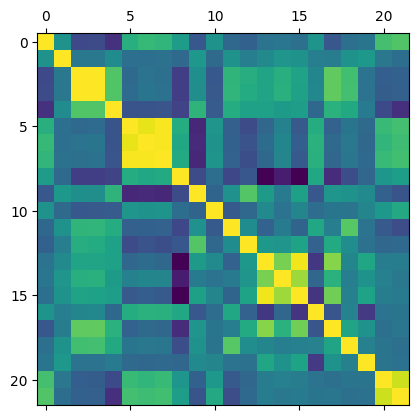

In [84]:
plt.matshow(combined_sdf.select_dtypes(['number']).corr())
plt.show()

<Axes: >

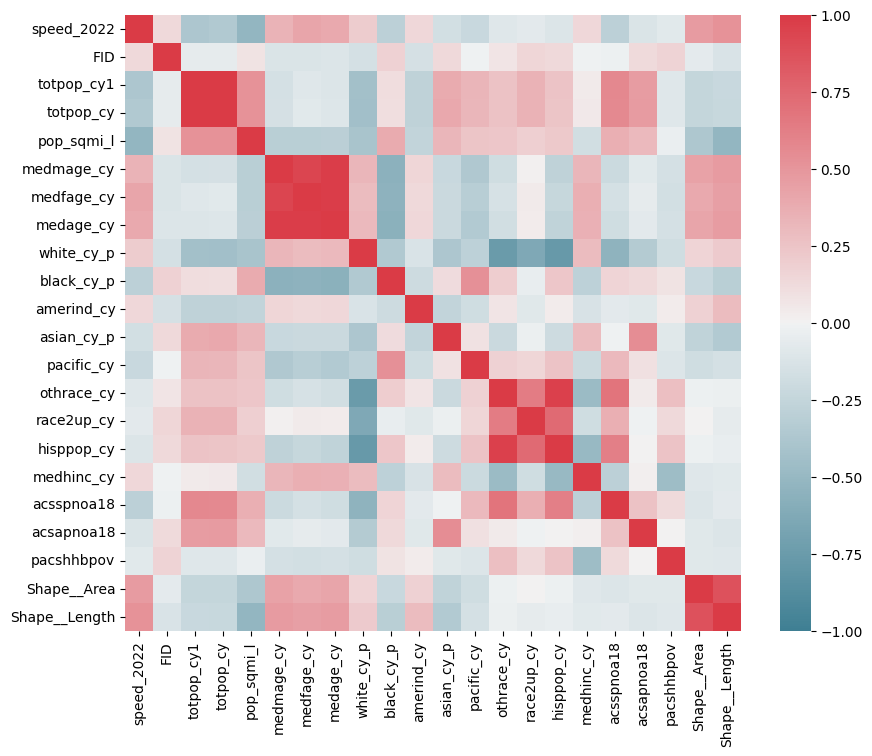

In [89]:
f, ax = plt.subplots(figsize=(10, 8))
corr = combined_sdf.select_dtypes(['number']).corr()
sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)

In [121]:
enriched_data = pd.DataFrame(combined_sdf)
enriched_data = enriched_data.drop(columns=["Shape__Length", "SHAPE", "po_name", "state"])


In [122]:
enriched_data.columns

Index(['zip_code', 'speed_2022', 'FID', 'totpop_cy1', 'totpop_cy',
       'pop_sqmi_l', 'medmage_cy', 'medfage_cy', 'medage_cy', 'white_cy_p',
       'black_cy_p', 'amerind_cy', 'asian_cy_p', 'pacific_cy', 'othrace_cy',
       'race2up_cy', 'hisppop_cy', 'medhinc_cy', 'acsspnoa18', 'acsapnoa18',
       'pacshhbpov', 'Shape__Area'],
      dtype='object')

In [125]:
X = enriched_data.drop(columns=["speed_2022"])  # Features
y = enriched_data["speed_2022"]  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [133]:
rf = RandomForestRegressor(n_estimators=1000, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=1000, random_state=42)

In [134]:
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {r2:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

R² Score: 0.35
Mean Absolute Error: 5.16


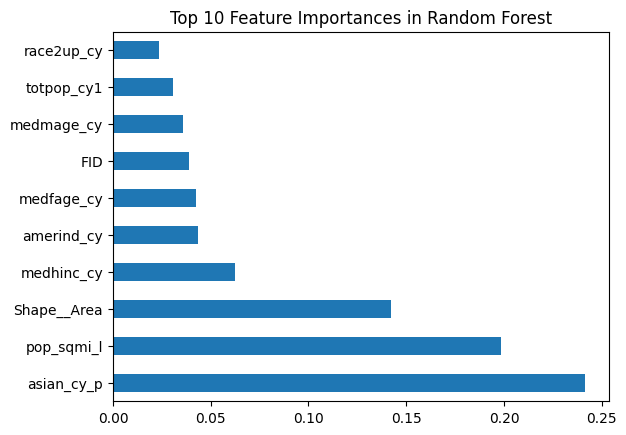

In [135]:
feature_importance = pd.Series(rf.feature_importances_, index=X.columns)
feature_importance.nlargest(10).plot(kind="barh")
plt.title("Top 10 Feature Importances in Random Forest")
plt.show()

In [140]:
enriched_data.columns

Index(['zip_code', 'speed_2022', 'FID', 'totpop_cy1', 'totpop_cy',
       'pop_sqmi_l', 'medmage_cy', 'medfage_cy', 'medage_cy', 'white_cy_p',
       'black_cy_p', 'amerind_cy', 'asian_cy_p', 'pacific_cy', 'othrace_cy',
       'race2up_cy', 'hisppop_cy', 'medhinc_cy', 'acsspnoa18', 'acsapnoa18',
       'pacshhbpov', 'Shape__Area'],
      dtype='object')

<Axes: >

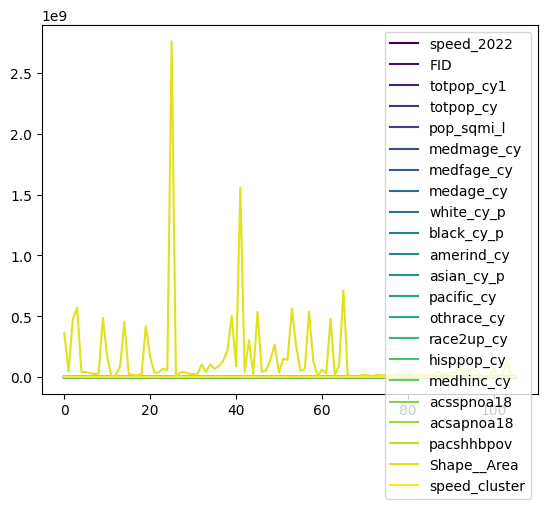

In [141]:
cluster_features = enriched_data[["speed_2022", "pop_sqmi_l", "totpop_cy"]]

# Apply K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
enriched_data["speed_cluster"] = kmeans.fit_predict(cluster_features)

# Plot clusters
enriched_data.plot(column="speed_cluster", cmap="viridis", legend=True)

In [143]:
features = ["speed_2022", "pop_sqmi_l", "totpop_cy"]
X_cluster = combined_sdf[features].copy()  # Extract relevant columns

In [144]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

In [147]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
combined_sdf["cluster"] = kmeans.fit_predict(X_scaled)

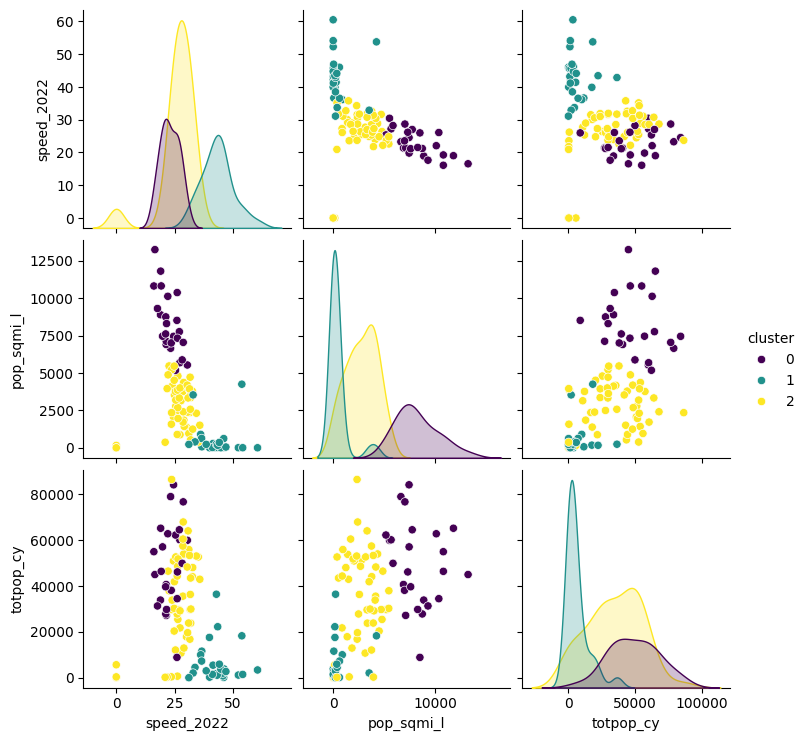

In [148]:
sns.pairplot(combined_sdf, hue="cluster", vars=["speed_2022", "pop_sqmi_l", "totpop_cy"], palette="viridis")
plt.show()

In [154]:
combined_sdf.cluster

0      1
1      2
2      1
3      1
4      0
      ..
101    2
102    1
103    2
104    0
105    2
Name: cluster, Length: 106, dtype: int32

In [155]:
map8 = gis.map("San Diego, CA")

cluster_renderer = {
    "type": "uniqueValue",
    "field1": "cluster",
    "uniqueValueInfos": [
        {
            "value": "0",
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [252, 101, 66, 100],  # Transparent fill
                "outline": {
                    "color": [252, 101, 66, 255],  # Red outline for urban areas
                    "width": 1.5,
                },
            },
            "label": "Cluster 0",
        },
        {
            "value": "1",
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [162, 190, 149, 100],  # Transparent fill
                "outline": {
                    "color": [162, 190, 149, 255],  # Green outline for suburban areas
                    "width": 1.5,
                },
            },
            "label": "Cluster 1",
        },
        {
            "value": "2",
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [55, 94, 151, 100],  # Transparent fill
                "outline": {
                    "color": [55, 94, 151, 255],  # Blue outline for rural areas
                    "width": 1.5,
                },
            },
            "label": "Cluster 2",
        },
    ],
}

map8.content.add(combined_sdf, drawing_info={"renderer": cluster_renderer})
map8.legend.enabled = True
map8

Map(center=[3857636.3466711883, -13042616.481232138], extent={'xmin': -13075789.689488532, 'ymin': 3818273.910…

# 11) Analysis

To properly analyze the data we attempt to use a regressor to find relationships between all of our enriched data and the average speed.  We first created a heatmap to show the relationships between the data, and we the various age factors as more strongly correlated with the speed.  We then train a random forest regressor on the data, and attempt to analyze the most common factors, seen in the top 10 most important factors graph.  We want to draw attention to the second most related value, the population per square mile.  This ties into our earlier evaluation of speed on road data when plotted, where we saw variance in speed according to population centers.  We saw lower speeds in more populated areas like down town San Diego or here in La Jolla, wheras the roads leading out into the desert near Anza Borrego have higher average speeds, which is in part due to them mainly being highways.  The asian population being most correlated is interesting, but we believe it to be a quirk of the data more than anything compelling.

Our next goal of analysis was to see if different areas of zipcodes were related using K-means clustering with three clusters to match the rural, suburban, urban.  This leads to the final map showing the three clusters located.  This clusters are quite interesting, showing a strong grouping that calls back to the prior speed map, but has some results that differ.  On the map we see the red cluster, which in large part covers most of down town San Diego.  This makes most sense as the speed should be fairly consistent around down town.  But we also see the zip code containing UCSD as also marked as red.  We are seeing a relationship between the speeds in down town as well as around campus, which could be related to students and their travel plans.  Also note the red cluster in Mira Mesa, which could also be similar to the two areas discussed earlier.  Beyond this we see the second cluster, which strongly resembles the suburban grouping.  This could be due to people traveling at similar speeds through suburbs, possibly due to standard speed limits imposed on the size of roads found in suburbs.  And finally we see the large open spaces clustered together, which follows our population evaluations.